# Determination of diffusion constants
This notebook demonstrates two ways of determining 2D diffusion constants using single molecule microscopy data
- fitting the slope and intercept of a lag time vs. MSD (mean squared deviation) plot
- fitting the CDFs of the square displacements

In [2]:
# Import necessary packages
%matplotlib inline
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
import trackpy
trackpy.quiet()

from sdt import io, motion, config, helper

## Download example data

Get the zip file from [here](https://github.com/schuetzgroup/sdt-python-tutorials/releases/download/data/data-diffconst.zip)
and extract it where this notebook is.
This should give you a ``data-diffconst`` subfolder containing several image sequences of single molecule data.

Of course you can also use your own data.

## Locate single molecules

Launch a GUI for selecting an algorithm an appropriate parameters for single-molecule localization.
For this

- Load the files by clicking "Add…" and selecting
- Double-click a file to show a preview
- Select an algorithm (here, "cg" was used)
- Select parameters (here, 
    - radius = 2
    - Signal threshold = 100
    - Mass threshold = 750)
- Verify settings by looking at several files and frames
- Click "Locate and save" in the bottom left corner
- Close the window, as no further code cells can be run until the GUI is stopped.

This should produce one file ending in ".h5" for each image sequence containing the localization data and 
one ".yaml" file describing the algorithm and parameter.

In [3]:
# Launch GUI
# On Windows, the GUI may appear somewhere behind other windows
!python -m sdt.gui.locator

## Single-molecule tracking

First, load the localization data created in the previous step.

In [4]:
data_dir = Path("data-diffconst")  # adjust accordingly

# Localization data is in the .h5 files
loc_files = sorted(data_dir.glob("*.h5"))
# Use sdt.io.load to load each file
loc_data = [io.load(f) for f in loc_files]

Each single-molecule localization data is represented by a line in a table.
The columns give the according parameters, like x and y coordinates, the signal 
amplitude (`signal`), the total intensity (`mass`), the local background per 
pixel (`bg`), the radius (`size`), and the frame number.

In [5]:
loc_data[0].head()

,x,y,mass,size,ecc,frame
0,69.212118,2.542938,1377.727560,1.385835,0.255051,0
1,71.529092,2.579984,1157.599384,1.563691,0.335043,0
2,5.631415,4.242856,1217.830711,1.513729,0.326804,0
3,44.815184,5.837233,869.139701,1.470629,0.271496,0
4,47.498069,5.818325,1897.841722,1.496071,0.116886,0


Localizations are linked into tracks using the `trackpy` package.

Inspection of the movies suggests that molecules travel less than 3 pixels between frames, thus set `search_range = 3`.
Allow for missed localizations by setting `memory = 1`.

In [6]:
search_range = 5
memory = 1
trc_data = [trackpy.link_df(d, search_range, memory=memory) for d in loc_data]

Trackpy adds a `particle` column to the tables, which identifies trajectories.

In [7]:
trc_data[0].head()

,x,y,mass,size,ecc,frame,particle
0,69.212118,2.542938,1377.727560,1.385835,0.255051,0,0
98,16.162283,93.391147,793.102851,1.337286,0.114906,0,1
97,111.016708,90.133385,806.846225,1.404384,0.250821,0,2
96,63.711274,90.280541,1930.715531,1.381761,0.058513,0,3
95,29.304773,90.276940,1482.198752,1.313525,0.092182,0,4


Next, filter trajectories. 
Here, any tracks with less than 5 localizations will be discarded.
It is possible to add additional filters as needed.

In [8]:
min_length = 5
trc_filtered = [t.groupby("particle").filter(lambda d: len(d) >= min_length) 
                for t in trc_data]

## Calculate diffusion coefficients from MSDs

First, pixels need to be converted into μm and frame number to seconds.

In [9]:
pixel_size = 0.16  # pixel size in μm
fps = 100  # frames per second
exposure_time = 0.004  # seconds

Calculate ensemble MSDs and standard errors in 1000 rounds of bootstrapping

In [10]:
msd_result = motion.Msd(trc_filtered, fps, n_lag=10, n_boot=1000, pixel_size=pixel_size)
m, e = msd_result.get_msd()

In [11]:
m  # MSDs

lagt
0.01    0.033115
0.02    0.060904
0.03    0.088196
0.04    0.115652
0.05    0.143012
0.06    0.168887
0.07    0.195510
0.08    0.222150
0.09    0.248643
0.10    0.275621
Name: ensemble, dtype: float64

In [12]:
e  # standard errors

lagt
0.01    0.000229
0.02    0.000380
0.03    0.000532
0.04    0.000701
0.05    0.000907
0.06    0.001037
0.07    0.001265
0.08    0.001435
0.09    0.001686
0.10    0.001954
Name: ensemble, dtype: float64

Now, fit a linear (Brownian) model to the results, using only the first two lag times and plot the results.
Account for motion during exposure.

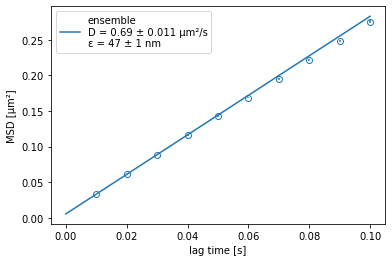

In [13]:
fit_result = msd_result.fit("brownian", n_lag=2, exposure_time=exposure_time)
fig, ax = plt.subplots()
fit_result.plot(ax=ax)

Fitting an anomalous model is supported as well.
However, exposure time compensation is computationally expensive in this case and the fit can take a few minutes.
Consider reducing the number of bootstrapping rounds, which was set to 1000 above.

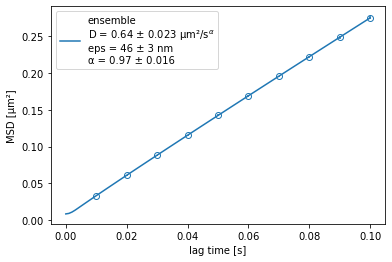

In [14]:
fit_result_ano = msd_result.fit("anomalous", exposure_time=exposure_time)
fit_result_ano.plot()

It is also possible to calculate MSDs and fit results individually for each track by setting `ensemble = False`.

In [15]:
msd_result_ind = motion.Msd(trc_filtered, fps, n_lag=10, ensemble=False, n_boot=100)
mi, ei = msd_result_ind.get_msd()

In [16]:
mi

lagt               0.01      0.02      0.03      0.04      0.05       0.06  \
file particle                                                                
0    1         1.228769  2.479449  3.752335  5.210911  6.704611   8.771279   
     2         1.295761  3.095101  3.672923  5.290416  5.404057   3.818655   
     3         1.325384  3.102829  4.027113  6.267075  7.349433   9.100158   
     4         1.533386  2.279904  2.860151  4.187908  4.680032   5.571320   
     5         4.703418  7.234873  6.875298  9.322612  8.954527  11.348023   
...                 ...       ...       ...       ...       ...        ...   
9    967       1.590572  3.194190  3.535899  5.135505  5.317722   2.183953   
     968       1.246474  2.382213  2.146956  3.894493  2.165905   4.558824   
     969       0.423189  2.062741  3.385679  7.064767  9.327513  10.636168   
     970       1.883300  3.246744  4.217882  6.023340  6.800641   7.028635   
     973       1.360312  1.987369  2.150303  3.632176  2.927826        NaN   

lagt                0.07       0.08       0.09       0.10  
file particle                                              
0    1         10.596984  12.008024  13.412429  15.228244  
     2          3.539496   2.059315   0.273488   0.514299  
     3         11.028646  11.700461  13.131987  14.948575  
     4          6.215156   6.042335   6.756272   8.330533  
     5          9.314399  11.855144  12.949598  13.346201  
...                  ...        ...        ...        ...  
9    967        0.307260   0.678055   0.603281        NaN  
     968        1.752611   1.483072        NaN        NaN  
     969             NaN        NaN        NaN        NaN  
     970        7.900612   7.912594   7.958318   9.121586  
     973             NaN        NaN        NaN        NaN  

[3367 rows x 10 columns]

In [17]:
fit_result_ind = msd_result_ind.fit("brownian", n_lag=2, exposure_time=exposure_time)
fit_result_ind.get_results()[0]

parameter              D       eps
file particle                     
0    1         31.266999  0.097379
     2         44.983510 -0.131778
     3         44.436135 -0.082546
     4         18.662961  0.439842
     5         63.286382  0.514468
...                  ...       ...
9    967       40.090462  0.068961
     968       28.393463  0.113103
     969       40.988808 -0.428546
     970       34.086103  0.311316
     973       15.676444  0.325881

[3367 rows x 2 columns]

## Calculate diffusion coefficients from distributions of squared deviations

By fitting the cumulative distribution function of the individual square displacements, it is also possible to deterine the diffusion constant.
It is even possible to identify different fractions of particles with by their diffusion speed.
For further information, please consult the documentation.

This is computationally more expensive than fitting of $t_\text{lag}$ vs. MSD curves.
Especially with bootstrapping this can take a few minutes.

In the following, a fit for two components with potentially differing diffusive behavior will be performed.

In [18]:
msd_cdf = motion.MsdDist(trc_filtered, fps, n_components=2, n_boot=100, pixel_size=pixel_size, n_lag=10)

In [19]:
res = msd_cdf.get_msd()

`res[i]` represents the i-th component and has following attributes:
- `msd`: MSDs
- `msd_err`: Standard errors of MSDs
- `weight`: Statistical weight of the i-th component
- `weight_err`: Standard errors of the weights

In [20]:
res[0].msd

lagt
0.01    0.009071
0.02    0.012048
0.03    0.011614
0.04    0.012025
0.05    0.010120
0.06    0.009077
0.07    0.010160
0.08    0.009171
0.09    0.008792
0.10    0.007637
Name: ensemble, dtype: float64

Perform a Brownian model fit for each component using all lag times.

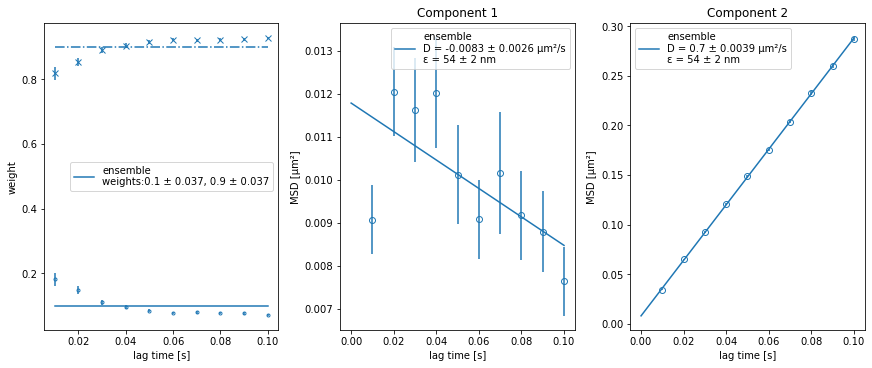

In [21]:
msd_cdf_fit = msd_cdf.fit("brownian", n_lag=np.inf, exposure_time=exposure_time)
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
msd_cdf_fit.plot(fig=fig);

This analysis can also be performed on a per-trajectory level by setting `ensemble = False` when creating the 
`motion.MsdDist` instance.
However, this is even more computationally expensive.